## TPE Tuning

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

In [5]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [7]:
imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(random_state=42),
    random_state=42,
)

imputer_missForest.fit(X_train)
X_train_missForest = imputer_missForest.transform(X_train)
X_test_missForest = imputer_missForest.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [8]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [9]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [10]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((425, 23), (183, 23))

In [11]:
model = RandomForestClassifier(random_state=42,)

# let's initialize Boruta
sel = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
)

sel.fit(X_train_t.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	7
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	11
Itera

BorutaPy(estimator=RandomForestClassifier(n_estimators=46,
                                          random_state=RandomState(MT19937) at 0x19A76E4FD40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x19A76E4FD40, verbose=2)

In [12]:
# Store selected feature names before transformation
selected_features = X_train_t.columns[sel.support_]
selected_features

Index(['RID', 'Ageatscreening', 'MMSE0m', 'HipsEntropybaseline',
       'ERCsContrastbaseline', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

In [13]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((425, 8), (183, 8))

## TPE

In [14]:
def objective(trial):
    
    
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 500)
    rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
    rf_max_depth = trial.suggest_int("rf_max_depth", 3, 4)
    rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.001, 0.2)
    rf_max_features = trial.suggest_categorical("rf_max_features", ["sqrt", "log2"])
    rf_min_samples_leaf = trial.suggest_float("rf_min_samples_leaf", 0.001, 0.1)
    rf_class_weight = trial.suggest_categorical("rf_class_weight", ["balanced", "balanced_subsample"])
        
    model = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                   criterion=rf_criterion,
                                   max_depth=rf_max_depth,
                                   min_samples_split=rf_min_samples_split,
                                   max_features=rf_max_features,
                                   min_samples_leaf=rf_min_samples_leaf,
                                   random_state=42, 
                                   class_weight=rf_class_weight)

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [15]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-03-16 00:24:14,598] A new study created in memory with name: no-name-661e2232-c369-46f7-bb18-a5697c59b8a8
[I 2025-03-16 00:24:30,049] Trial 0 finished with value: 0.5481990231990232 and parameters: {'rf_n_estimators': 419, 'rf_criterion': 'entropy', 'rf_max_depth': 4, 'rf_min_samples_split': 0.19631812044319888, 'rf_max_features': 'log2', 'rf_min_samples_leaf': 0.08358682146831943, 'rf_class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.5481990231990232.
[I 2025-03-16 00:24:42,246] Trial 1 finished with value: 0.5445299145299145 and parameters: {'rf_n_estimators': 412, 'rf_criterion': 'gini', 'rf_max_depth': 4, 'rf_min_samples_split': 0.12592016451533375, 'rf_max_features': 'sqrt', 'rf_min_samples_leaf': 0.09423095320086437, 'rf_class_weight': 'balanced'}. Best is trial 0 with value: 0.5481990231990232.
[I 2025-03-16 00:24:53,140] Trial 2 finished with value: 0.5303632478632478 and parameters: {'rf_n_estimators': 302, 'rf_criterion': 'entropy', 'rf_max_depth': 3

In [16]:
study.best_params

{'rf_n_estimators': 361,
 'rf_criterion': 'gini',
 'rf_max_depth': 3,
 'rf_min_samples_split': 0.04074104956371625,
 'rf_max_features': 'sqrt',
 'rf_min_samples_leaf': 0.06894623366824346,
 'rf_class_weight': 'balanced_subsample'}

In [17]:
study.best_value

0.5659920634920634

In [18]:
r = study.trials_dataframe()
r.head()

,number,value,datetime_start,datetime_complete,duration,params_rf_class_weight,params_rf_criterion,params_rf_max_depth,params_rf_max_features,params_rf_min_samples_leaf,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.548199,2025-03-16 00:24:14.601242,2025-03-16 00:24:30.048419,0 days 00:00:15.447177,balanced_subsample,entropy,4,log2,0.083587,0.196318,419,COMPLETE
1,1,0.544530,2025-03-16 00:24:30.050538,2025-03-16 00:24:42.245096,0 days 00:00:12.194558,balanced,gini,4,sqrt,0.094231,0.125920,412,COMPLETE
2,2,0.530363,2025-03-16 00:24:42.247095,2025-03-16 00:24:53.139963,0 days 00:00:10.892868,balanced,entropy,3,sqrt,0.071657,0.111149,302,COMPLETE
3,3,0.557198,2025-03-16 00:24:53.142047,2025-03-16 00:25:10.530809,0 days 00:00:17.388762,balanced_subsample,gini,4,log2,0.010824,0.078365,475,COMPLETE
4,4,0.542705,2025-03-16 00:25:10.531826,2025-03-16 00:25:18.564188,0 days 00:00:08.032362,balanced,entropy,4,log2,0.077006,0.111362,227,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_5848\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


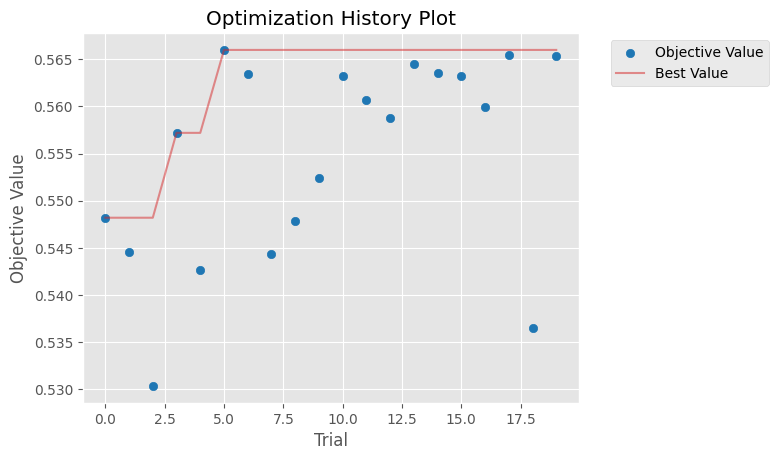

In [19]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_5848\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

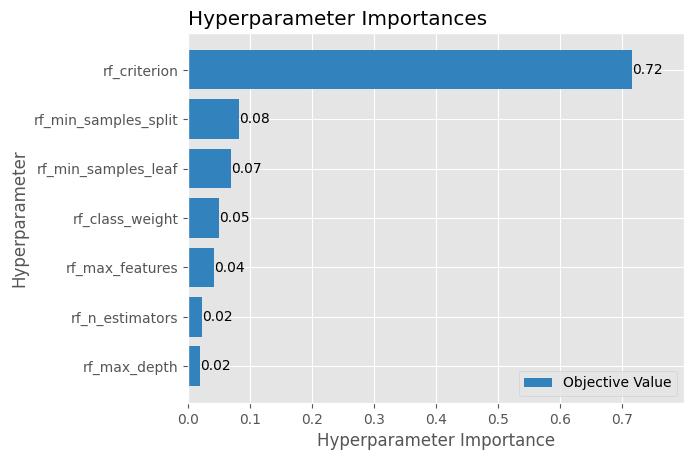

In [20]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_5848\3879122787.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='rf_class_weight', ylabel='Objective Value'>,
       <Axes: xlabel='rf_criterion'>, <Axes: xlabel='rf_max_depth'>,
       <Axes: xlabel='rf_max_features'>,
       <Axes: xlabel='rf_min_samples_leaf'>,
       <Axes: xlabel='rf_min_samples_split'>,
       <Axes: xlabel='rf_n_estimators'>], dtype=object)

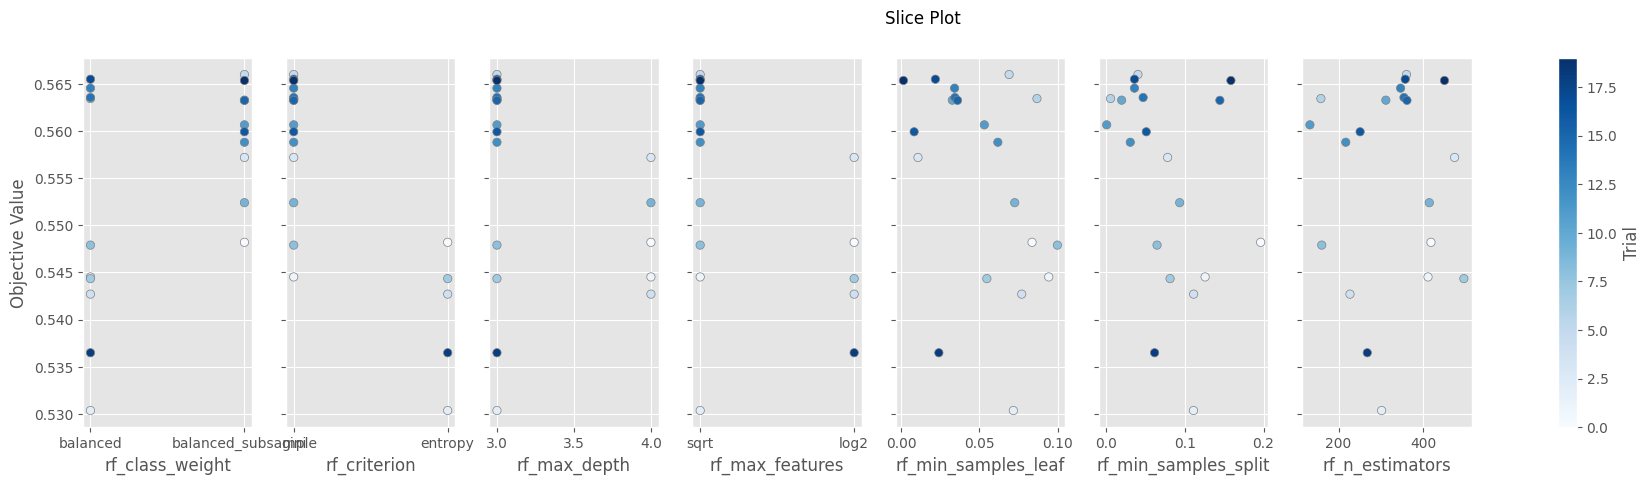

In [21]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["rf_n_estimators", "rf_criterion", "rf_max_depth", 
            'rf_min_samples_split', 'rf_max_features', 'rf_min_samples_leaf',
            'rf_class_weight'],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_5848\2601326980.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

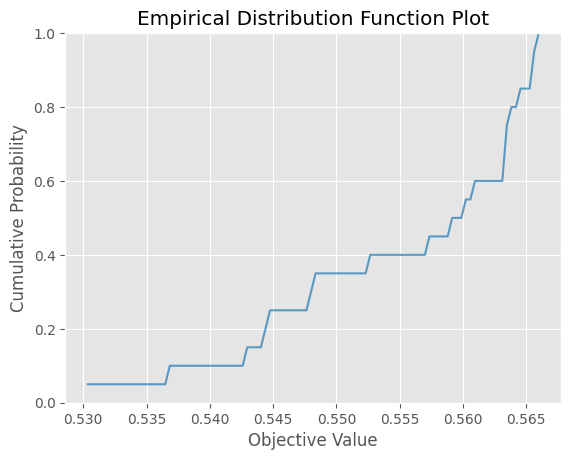

In [22]:
optuna.visualization.matplotlib.plot_edf([study])

## Classification

In [23]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = RandomForestClassifier(n_estimators=study.best_params["rf_n_estimators"], 
                                       criterion=study.best_params["rf_criterion"],
                                       max_depth=study.best_params["rf_max_depth"],
                                       min_samples_split=study.best_params["rf_min_samples_split"],
                                       max_features=study.best_params["rf_max_features"],
                                       min_samples_leaf=study.best_params["rf_min_samples_leaf"],
                                       random_state=42, 
                                       class_weight=study.best_params["rf_class_weight"])
        
        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [24]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", "Complete", X_train_missForest_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", "Boruta", X_train_t, y_train)

In [25]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [26]:
results = "all"
prediction_df_report = None

if results == "all":
    
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
  
    prediction_df = pd.concat([pred_rf_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier    Classification Time Total Features Metric                             
Boruta            Random Forest 0.690               23             accuracy                   0.706   
                                                                   balanced_accuracy          0.690   
                                                                   precision                  0.710   
                                                                   recall                     0.706   
                                                                   f1_weighted                0.684   
                                                                   roc_auc_ovr_weighted       0.871   
                                0.617               8              accuracy                   0.675   
                                                                   balanced_accuracy          0.666   
                                                                   precision                  0.683   
                                                                   recall                     0.675   
                                                                   f1_weighted                0.652   
                                                                   roc_auc_ovr_weighted       0.870   

                                                                                         Test data  
Feature Selection Classifier    Classification Time Total Features Metric                           
Boruta            Random Forest 0.690               23             accuracy                  0.514  
                                                                   balanced_accuracy         0.523  
                                                                   precision                 0.509  
                                                                   recall                    0.514  
                                                                   f1_weighted               0.492  
                                                                   roc_auc_ovr_weighted      0.777  
                                0.617               8              accuracy                  0.519  
                                                                   balanced_accuracy         0.532  
                                                                   precision                 0.514  
                                                                   recall                    0.519  
                                                                   f1_weighted               0.501  
                                                                   roc_auc_ovr_weighted      0.802

### Export model

In [38]:
trained_rf_t

RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       min_samples_leaf=0.06894623366824346,
                       min_samples_split=0.04074104956371625, n_estimators=361,
                       random_state=42)

In [68]:
import pickle

with open("rf_model.pkl", "wb") as file:
    pickle.dump(trained_rf_t, file)
    
print("Random Forest model saved successfully!")

Random Forest model saved successfully!
